Соревнование на платформе Zindi: [AirQo Ugandan Air Quality Forecast Challenge](https://zindi.africa/competitions/airqo-ugandan-air-quality-forecast-challenge) <br> <br>
Результат в основное время: **180/318**. Неудовлетворительно. Понимал, что даже для первого опыта можно было лучше.<br> <br>
После завершения соревнования получил решение, которое заняло бы **79 место** (к сожалению, о соревновании узнал только за неделю до окончания, плюс не знал пару приёмов, которые помогли улучшить счёт после). Им остался удовлетворён.<br> <br>
**Кратко о данных**: 4 локации, в которых установлены метеоизмерители. Имеются данные о температуре, влажности, осадках, скорости и направлении ветра, атмосферном давлении. А также немного данных о населении территорий, где стоят датчики. <br> <br>
**Задача**: предсказать загрязнение воздуха (уровень частиц pm2.5). <br> 
**Метрика**: RMSE <br>
**Train**: 15339 строк<br>
**Test**: 5035 строк <br>
Внутри строки — 120 показаний датчика по каждому признаку, раз в час на протяжении 5 дней. При этом никакой привязки к конкретным датам нет. <br> <br>
**Итоговый скор**: [34.00](https://prnt.sc/t03ooz) (решение победителя — 31.97, решение 50-го места — 33.73, решение в основное время — 35.71)




In [0]:
!pip install catboost

In [0]:
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.model_selection import RandomizedSearchCV

from lightgbm import LGBMRegressor

import xgboost as xgb
import catboost

In [0]:
from google.colab import files
df = pd.read_csv('Train (2).csv')
df_test = pd.read_csv('Test (2).csv')
meta = pd.read_csv('airqo_metadata (1).csv')
meta = meta.drop(columns=['dist_motorway', 'Unnamed: 0']).replace(np.nan, 5000) #данные о локациях, где стоят датчики.

In [4]:
df.head(3)

,ID,location,temp,precip,rel_humidity,wind_dir,wind_spd,atmos_press,target
0,ID_train_0,C,"nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...",45.126304
1,ID_train_1,D,"22.53333333,21.71666667,20.83333333,20.9833333...","0.102,0.0,0.0,0.0,0.0,0.0,0.0,0.034,0.017,0.01...","0.744583333,0.808083333,0.911166667,0.91633333...","281.6643101,89.15629262,81.96853891,291.018632...","2.3775,1.126666667,0.700833333,0.3416666670000...","90.32,90.3775,90.44083333,90.4725,90.45416667,...",79.131702
2,ID_train_10,A,"28.975,27.95,29.6,26.425,22.09166667,21.775,22...","0.0,0.0,0.0,0.102,0.136,0.0,0.0,2.16,1.276,0.0...","0.573333333,0.597166667,0.5668333329999999,0.6...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","88.55166667,88.46416667,88.31916667,88.24,88.2...",32.661304


In [5]:
meta.head(3)

,location,loc_altitude,km2,aspect,dist_trunk,dist_primary,dist_secondary,dist_tertiary,dist_unclassified,dist_residential,popn,hh,hh_cook_charcoal,hh_cook_firewood,hh_burn_waste
0,A,1122.4,1.9,194.0,5000.000000,14.695789,343.595039,575.917422,330.609776,254.307415,4763,809,508,43,142
1,B,1155.4,5.4,219.8,528.078476,2172.680462,1144.376412,531.103271,65.142004,1.042809,22243,5735,116,1144,239
2,C,1178.3,8.5,168.7,32.885520,4794.704552,12.730489,72.459340,406.967815,13.931350,97895,26873,21316,751,9835


<h3>Предобработка</h3>

Данные в достаточно неудобном виде. <br>
Первым этапом решено было создать 6 таблиц, по одной для каждого измерения, в каждой 120 столбцов — 120 наблюдений. <br>
Много пропущенных значений. Как я понял из логики, пропущенные значения означают неработающий датчик. Везде было принято решение заменить их нулями, которые потом, при необходимости, местами не учитывались в расчётах. <br><br>
За этот этап отвечает одна функция (примеры промежуточных результатов будут после).

In [0]:
def first_preparation(df):

  df_temp = pd.DataFrame()
  df_precip = pd.DataFrame()
  df_humid = pd.DataFrame()
  df_wind_dir = pd.DataFrame()
  df_wind_spd = pd.DataFrame()
  df_atmos_press = pd.DataFrame()

  temp = df.temp
  temp = temp.apply(lambda x: x.split(','))
  temp_dict = {'temp': temp}
  df_temp = pd.DataFrame(temp_dict)
  df_temp[[i for i in range(121)]] = pd.DataFrame(df_temp.temp.tolist(), index = df_temp.index)
  df_temp.drop('temp', axis = 1, inplace = True)

  precip = df.precip
  precip = precip.apply(lambda x: x.split(','))
  precip_dict = {'precip': precip}
  df_precip = pd.DataFrame(precip_dict)
  df_precip[[i for i in range(121)]] = pd.DataFrame(df_precip.precip.tolist(), index = df_precip.index)
  df_precip.drop('precip', axis = 1, inplace = True)

  rel_humidity = df.rel_humidity
  rel_humidity = rel_humidity.apply(lambda x: x.split(','))
  humid_dict = {'humid': rel_humidity}
  df_humid = pd.DataFrame(humid_dict)
  df_humid[[i for i in range(121)]] = pd.DataFrame(df_humid.humid.tolist(), index = df_humid.index)
  df_humid.drop('humid', axis = 1, inplace = True)

  wind_dir	 = df.wind_dir	
  wind_dir	 = wind_dir	.apply(lambda x: x.split(','))
  wind_dir_dict = {'wind_dir': wind_dir}
  df_wind_dir = pd.DataFrame(wind_dir_dict)
  df_wind_dir[[i for i in range(121)]] = pd.DataFrame(df_wind_dir.wind_dir.tolist(), index = df_wind_dir.index)
  df_wind_dir.drop('wind_dir', axis = 1, inplace = True)

  wind_spd = df.wind_spd
  wind_spd = wind_spd.apply(lambda x: x.split(','))
  windspd_dict = {'wind_spd': wind_spd}
  df_wind_spd = pd.DataFrame(windspd_dict)
  df_wind_spd[[i for i in range(121)]] = pd.DataFrame(df_wind_spd.wind_spd.tolist(), index = df_wind_spd.index)
  df_wind_spd.drop('wind_spd', axis = 1, inplace = True)

  atmos_press = df.atmos_press
  atmos_press = atmos_press.apply(lambda x: x.split(','))
  atmos_press_dict = {'atmos_press': atmos_press}
  df_atmos_press = pd.DataFrame(atmos_press_dict)
  df_atmos_press[[i for i in range(121)]] = pd.DataFrame(df_atmos_press.atmos_press.tolist(), index = df_atmos_press.index)
  df_atmos_press.drop('atmos_press', axis = 1, inplace = True)

  print('First preparation: done')

  return df_temp, df_precip, df_humid, df_wind_dir, df_wind_spd, df_atmos_press

Следующая функция работает с каждой таблицей в отдельности, чтобы привести её в уже действительно рабочий вид и выполнить первичные вычисления.

In [0]:
def preparation(dataset, wind_dir = False): 
  if wind_dir: # требует отдельного рассмотрения, так как у направления ветра нас интересует не среднее, а медиана
    dataset = dataset.replace('nan', 0)
    dataset = dataset.astype('float')
    dataset['not_zero'] = dataset.astype(bool).astype(int).sum(axis = 1)
    dataset['median_dir'] = dataset[dataset != 0].round(-1).median(axis = 1)
    dataset['location'] = df.location
    dataset['median_dir_loc'] = dataset.groupby('location')['median_dir'].transform('median')
    dataset.drop(columns='location', inplace = True)
  else:
    dataset = dataset.replace('nan', 0)
    dataset = dataset.astype('float')
    row_sum = dataset.sum(axis = 1)
    dataset['not_zero'] = dataset.astype(bool).astype(int).sum(axis = 1)
    dataset['location'] = df.location
    dataset['average'] = row_sum / dataset['not_zero'] #считаем среднее, не искажая его нулями, которые появились из-за простоя датчика
    dataset['mean_loc'] = dataset.groupby('location')['average'].transform('mean')
    dataset.drop(columns='location', inplace = True)
  return dataset

Подготовим данные для train и test

In [8]:
df_temp, df_precip, df_humid, df_wind_dir, df_wind_spd, df_atmos_press = first_preparation(df)
df_temp_test, df_precip_test, df_humid_test, df_wind_dir_test, df_wind_spd_test, df_atmos_press_test = first_preparation(df_test)

First preparation: done
First preparation: done


In [9]:
df_atmos_press.head(3) # пример полученной таблицы

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120
0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,87.77727273,87.6525,87.61416667,87.6375,87.7175,87.7625,87.79083333,87.81416667,87.85833333,87.87166667,87.8025,87.76166667,87.74333333,87.71583333,87.75083333,87.76833333
1,90.32,90.3775,90.44083333,90.4725,90.45416667,90.39416667,90.33333333,90.31083333,90.34333333,90.36333333,90.36583333,90.42916667,90.44,90.51416667,90.55166667,90.57,90.56,90.51166667,90.40583333,90.29416667,90.17333333,90.09333333,90.05666667,90.08166667,90.155,90.21916667,90.3325,90.38,90.3775,90.35083333,90.31,90.27333333,90.29083333,90.33583333,90.39,90.4475,90.45833333,90.58083333,90.6425,90.6925,...,90.33833333,90.38,90.41166667,90.47,90.53416667,90.6175,90.66583333,90.66833333,90.555,90.43416667,90.38916667,90.39166667,90.34416667,90.31166667,90.30166667,90.36833333,90.4625,90.56333333,90.64666667,90.67833333,90.68166667,90.63416667,90.56,90.51166667,90.46583333,90.51583333,90.56333333,90.60333333,90.6825,90.725,90.7075,90.6825,90.60416667,90.48166667,90.35416667,90.2725,90.26666667,90.32583333,90.43916667,90.52916667
2,88.55166667,88.46416667,88.31916667,88.24,88.23,88.26833333,88.37,88.52,88.56333333,88.645,88.69666667,88.73083333,88.75166667,88.66916667,88.62,88.62833333,88.63,88.62333333,88.62,88.7275,88.76333333,88.77416667,88.81333333,88.74833333,88.65583333,88.54416667,88.425,88.31416667,88.23416667,88.2875,88.35166667,88.405,88.5075,88.5825,88.65,88.62416667,88.58166667,88.535,88.49583333,88.445,...,88.4225,88.485,88.53666667,88.53833333,88.46583333,88.4175,88.38583333,88.38083333,88.39,88.41833333,88.45083333,88.50416667,88.5225,88.505,88.43333333,88.35666667,88.27833333,88.16166667,88.05916667,88.00166667,87.9825,88.00583333,88.06416667,88.15416667,88.28083333,88.34583333,88.41916667,88.43916667,88.37416667,88.335,88.2875,88.30166667,88.35333333,88.40916667,88.44833333,88.5,88.495,88.51583333,88.47583333,88.41583333


Обработаем второй функцией (добавляем суффиксы, чтобы не возникло конфликта с неймингом фичей):

In [0]:
df_temp = preparation(df_temp, wind_dir = False)
df_temp = df_temp.add_suffix('_temp')
df_precip = preparation(df_precip, wind_dir = False)
df_precip = df_precip.add_suffix('_precip')
df_precip = df_precip.fillna(0) #количество осадков может быть нулевым, мешало подсчёту, возникали nan'ы
df_humid = preparation(df_humid, wind_dir = False)
df_humid = df_humid.add_suffix('_humid')
df_wind_spd = preparation(df_wind_spd, wind_dir = False)
df_wind_spd = df_wind_spd.add_suffix('_wind_spd')
df_atmos_press = preparation(df_atmos_press, wind_dir = False)
df_atmos_press = df_atmos_press.add_suffix('_atmos_press')
df_wind_dir = preparation(df_wind_dir, wind_dir = True)
df_wind_dir = df_wind_dir.add_suffix('_wind_dir')

df_temp_test = preparation(df_temp_test, wind_dir = False)
df_temp_test = df_temp_test.add_suffix('_temp')
df_precip_test = preparation(df_precip_test, wind_dir = False)
df_precip_test = df_precip_test.add_suffix('_precip')
df_precip_test = df_precip_test.fillna(0)
df_humid_test = preparation(df_humid_test, wind_dir = False)
df_humid_test = df_humid_test.add_suffix('_humid')
df_wind_spd_test = preparation(df_wind_spd_test, wind_dir = False)
df_wind_spd_test = df_wind_spd_test.add_suffix('_wind_spd')
df_atmos_press_test = preparation(df_atmos_press_test, wind_dir = False)
df_atmos_press_test = df_atmos_press_test.add_suffix('_atmos_press')
df_wind_dir_test = preparation(df_wind_dir_test, wind_dir = True)
df_wind_dir_test = df_wind_dir_test.add_suffix('_wind_dir')

In [11]:
df_atmos_press.head(3) # пример полученной таблицы

,0_atmos_press,1_atmos_press,2_atmos_press,3_atmos_press,4_atmos_press,5_atmos_press,6_atmos_press,7_atmos_press,8_atmos_press,9_atmos_press,10_atmos_press,11_atmos_press,12_atmos_press,13_atmos_press,14_atmos_press,15_atmos_press,16_atmos_press,17_atmos_press,18_atmos_press,19_atmos_press,20_atmos_press,21_atmos_press,22_atmos_press,23_atmos_press,24_atmos_press,25_atmos_press,26_atmos_press,27_atmos_press,28_atmos_press,29_atmos_press,30_atmos_press,31_atmos_press,32_atmos_press,33_atmos_press,34_atmos_press,35_atmos_press,36_atmos_press,37_atmos_press,38_atmos_press,39_atmos_press,...,84_atmos_press,85_atmos_press,86_atmos_press,87_atmos_press,88_atmos_press,89_atmos_press,90_atmos_press,91_atmos_press,92_atmos_press,93_atmos_press,94_atmos_press,95_atmos_press,96_atmos_press,97_atmos_press,98_atmos_press,99_atmos_press,100_atmos_press,101_atmos_press,102_atmos_press,103_atmos_press,104_atmos_press,105_atmos_press,106_atmos_press,107_atmos_press,108_atmos_press,109_atmos_press,110_atmos_press,111_atmos_press,112_atmos_press,113_atmos_press,114_atmos_press,115_atmos_press,116_atmos_press,117_atmos_press,118_atmos_press,119_atmos_press,120_atmos_press,not_zero_atmos_press,average_atmos_press,mean_loc_atmos_press
0,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0000,...,0.000000,0.000000,0.0000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,87.777273,87.652500,87.614167,87.637500,87.717500,87.7625,87.790833,87.814167,87.858333,87.871667,87.802500,87.761667,87.743333,87.715833,87.750833,87.768333,16,87.752434,87.776306
1,90.320000,90.377500,90.440833,90.4725,90.454167,90.394167,90.333333,90.310833,90.343333,90.363333,90.365833,90.429167,90.440000,90.514167,90.551667,90.570000,90.56,90.511667,90.405833,90.294167,90.173333,90.093333,90.056667,90.081667,90.155000,90.219167,90.3325,90.380000,90.377500,90.350833,90.310000,90.273333,90.290833,90.335833,90.39,90.447500,90.458333,90.580833,90.642500,90.6925,...,90.470000,90.534167,90.6175,90.665833,90.668333,90.555,90.434167,90.389167,90.391667,90.344167,90.311667,90.301667,90.368333,90.462500,90.563333,90.646667,90.678333,90.681667,90.634167,90.560000,90.511667,90.465833,90.515833,90.563333,90.603333,90.682500,90.7250,90.707500,90.682500,90.604167,90.481667,90.354167,90.272500,90.266667,90.325833,90.439167,90.529167,121,90.429924,90.569972
2,88.551667,88.464167,88.319167,88.2400,88.230000,88.268333,88.370000,88.520000,88.563333,88.645000,88.696667,88.730833,88.751667,88.669167,88.620000,88.628333,88.63,88.623333,88.620000,88.727500,88.763333,88.774167,88.813333,88.748333,88.655833,88.544167,88.4250,88.314167,88.234167,88.287500,88.351667,88.405000,88.507500,88.582500,88.65,88.624167,88.581667,88.535000,88.495833,88.4450,...,88.538333,88.465833,88.4175,88.385833,88.380833,88.390,88.418333,88.450833,88.504167,88.522500,88.505000,88.433333,88.356667,88.278333,88.161667,88.059167,88.001667,87.982500,88.005833,88.064167,88.154167,88.280833,88.345833,88.419167,88.439167,88.374167,88.3350,88.287500,88.301667,88.353333,88.409167,88.448333,88.500000,88.495000,88.515833,88.475833,88.415833,120,88.420931,88.430855


<h3>Feature Engineering</h3>

Созданы следующие фичи:
- Min, max, mean (median для направления ветра), std для каждого показателя.
- Некоторые межгрупповые отношения, которые могли иметь смысл. 
- Дополнительные фичи, выявляющие отношения величин в мета-данных. 
- Фичи, связанные с таргетом (так как одни и те же локации на трейне и на тесте, мы можем выявить опять же min/max/mean/std загрязнения по локации — это ожидаемо дало большой прирост качеству)


In [0]:
X = pd.DataFrame()
X['location'] = df.location
X['mean_target_per_loc'] = X.merge(df.groupby('location')['target'].agg('mean'), how = 'left', left_on = X.location, right_on = df.groupby('location')['target'].agg('mean').index).drop(columns = 'key_0')['target']
X['max_target_per_loc'] = X.merge(df.groupby('location')['target'].agg('max'), how = 'left', left_on = X.location, right_on = df.groupby('location')['target'].agg('max').index).drop(columns = 'key_0')['target']
X['min_target_per_loc'] = X.merge(df.groupby('location')['target'].agg('min'), how = 'left', left_on = X.location, right_on = df.groupby('location')['target'].agg('min').index).drop(columns = 'key_0')['target']
X['median_target_per_loc'] = X.merge(df.groupby('location')['target'].agg('median'), how = 'left', left_on = X.location, right_on = df.groupby('location')['target'].agg('median').index).drop(columns = 'key_0')['target']
X['std_target_per_loc'] = X.merge(df.groupby('location')['target'].agg('std'), how = 'left', left_on = X.location, right_on = df.groupby('location')['target'].agg('std').index).drop(columns = 'key_0')['target']
X = X.merge(meta, how = 'left', left_on = X.location, right_on = meta.location).drop(columns = ['key_0', 'location_y'])
X = pd.concat([X, df_temp, df_precip, df_humid, df_wind_dir, df_wind_spd, df_atmos_press], axis = 1) # закинем в качестве фичей также показатели в каждый час

le = LabelEncoder()
X.location_x = le.fit_transform(X.location_x)

X['max_temp'] = df_temp.iloc[:, :-3].max(axis = 1)
X['min_temp'] = df_temp[df_temp != 0].iloc[:, :-3].min(axis = 1)
X['std_temp'] = df_temp[df_temp != 0].iloc[:, :-3].std(axis = 1)
X['ratio_with_loc_temp'] = df_temp.average_temp / df_temp.mean_loc_temp

X['max_precip'] = df_precip.iloc[:, :-3].max(axis = 1)
X['min_precip'] = df_precip.iloc[:, :-3].min(axis = 1)
X['std_precip'] = df_precip.iloc[:, :-3].std(axis = 1)
X['sum_precip'] = df_precip[df_precip != 0].iloc[:, :-3].sum(axis = 1)

X['max_humid'] = df_humid.iloc[:, :-3].max(axis = 1)
X['ratio_humid'] = X.average_humid / X.mean_loc_humid
X['std_humid'] = df_humid[df_humid != 0].iloc[:, :-3].std(axis = 1)

X['ratio_atmos_press'] = X.average_atmos_press / X.mean_loc_atmos_press
X['max_atmos_press'] = df_atmos_press.iloc[:, :-3].max(axis = 1)
X['min_atmos_press'] = df_atmos_press[df_atmos_press != 0].iloc[:, :-3].min(axis = 1)
X['std_atmos_press'] = df_atmos_press[df_atmos_press != 0].iloc[:, :-3].std(axis = 1)
X['minmax_atmos_press'] = X.max_atmos_press - X.min_atmos_press

X['ratio_with_loc_wind_spd'] = df_wind_spd.average_wind_spd / df_wind_spd.mean_loc_wind_spd
X['max_wind_spd'] = df_wind_spd.iloc[:, :-3].max(axis = 1)
X['min_wind_spd'] = df_wind_spd.iloc[:, :-3].min(axis = 1)
X['std_wind_spd'] = df_wind_spd.iloc[:, :-3].std(axis = 1)
X['minmax_wind_spd'] = X.max_wind_spd - X.min_wind_spd

X['diff_wind_dir'] = X.median_dir_wind_dir / X.median_dir_loc_wind_dir

X['atmos_temp_ratio'] = X.average_atmos_press / X.average_temp
X['atmos_wind_ration'] = X.minmax_atmos_press / X.minmax_wind_spd

X['meta_houses_per_km'] = X['hh'] / X['km2']
X['meta_people_per_km'] = X['popn'] / X['km2']
X['meta_percent_burn'] = X['hh_burn_waste'] / X['hh']
X['meta_people_per_hh'] = X['popn'] / X['hh']
X['meta_mean_dist'] = (X['dist_trunk'] + X['dist_primary'] + X['dist_secondary'] + X['dist_unclassified'] + X['dist_residential'])/5

In [0]:
X_test = pd.DataFrame()
X_test['location'] = df_test.location
X_test['mean_target_per_loc'] = X_test.merge(df.groupby('location')['target'].agg('mean'), how = 'left', left_on = X_test.location, right_on = df.groupby('location')['target'].agg('mean').index).drop(columns = 'key_0')['target']
X_test['max_target_per_loc'] = X_test.merge(df.groupby('location')['target'].agg('max'), how = 'left', left_on = X_test.location, right_on = df.groupby('location')['target'].agg('max').index).drop(columns = 'key_0')['target']
X_test['min_target_per_loc'] = X_test.merge(df.groupby('location')['target'].agg('min'), how = 'left', left_on = X_test.location, right_on = df.groupby('location')['target'].agg('min').index).drop(columns = 'key_0')['target']
X_test['median_target_per_loc'] = X_test.merge(df.groupby('location')['target'].agg('median'), how = 'left', left_on = X_test.location, right_on = df.groupby('location')['target'].agg('median').index).drop(columns = 'key_0')['target']
X_test['std_target_per_loc'] = X_test.merge(df.groupby('location')['target'].agg('std'), how = 'left', left_on = X_test.location, right_on = df.groupby('location')['target'].agg('std').index).drop(columns = 'key_0')['target']
X_test = X_test.merge(meta, how = 'left', left_on = X_test.location, right_on = meta.location).drop(columns = ['key_0', 'location_y'])
X_test = pd.concat([X_test, df_temp_test, df_precip_test, df_humid_test, df_wind_dir_test, df_wind_spd_test, df_atmos_press_test], axis = 1)

X_test.location_x = le.fit_transform(X_test.location_x)

X_test['max_temp'] = df_temp_test.iloc[:, :-3].max(axis = 1)
X_test['min_temp'] = df_temp_test[df_temp_test != 0].iloc[:, :-3].min(axis = 1)
X_test['std_temp'] = df_temp_test[df_temp_test != 0].iloc[:, :-3].std(axis = 1)
X_test['ratio_with_loc_temp'] = df_temp_test.average_temp / df_temp_test.mean_loc_temp

X_test['max_precip'] = df_precip_test.iloc[:, :-3].max(axis = 1)
X_test['min_precip'] = df_precip_test.iloc[:, :-3].min(axis = 1)
X_test['std_precip'] = df_precip_test.iloc[:, :-3].std(axis = 1)
X_test['sum_precip'] = df_precip_test[df_precip != 0].iloc[:, :-3].sum(axis = 1)

X_test['max_humid'] = df_humid_test.iloc[:, :-3].max(axis = 1)
X_test['ratio_humid'] = X_test.average_humid / X_test.mean_loc_humid
X_test['std_humid'] = df_humid_test[df_humid_test != 0].iloc[:, :-3].std(axis = 1)

X_test['ratio_atmos_press'] = X_test.average_atmos_press / X_test.mean_loc_atmos_press
X_test['max_atmos_press'] = df_atmos_press_test.iloc[:, :-3].max(axis = 1)
X_test['min_atmos_press'] = df_atmos_press_test[df_atmos_press_test != 0].iloc[:, :-3].min(axis = 1)
X_test['std_atmos_press'] = df_atmos_press_test[df_atmos_press_test != 0].iloc[:, :-3].std(axis = 1)
X_test['minmax_atmos_press'] = X_test.max_atmos_press - X_test.min_atmos_press

X_test['ratio_with_loc_wind_spd'] = df_wind_spd_test.average_wind_spd / df_wind_spd_test.mean_loc_wind_spd
X_test['max_wind_spd'] = df_wind_spd_test.iloc[:, :-3].max(axis = 1)
X_test['min_wind_spd'] = df_wind_spd_test.iloc[:, :-3].min(axis = 1)
X_test['std_wind_spd'] = df_wind_spd_test.iloc[:, :-3].std(axis = 1)
X_test['minmax_wind_spd'] = X_test.max_wind_spd - X_test.min_wind_spd

X_test['diff_wind_dir'] = X_test.median_dir_wind_dir / X_test.median_dir_loc_wind_dir

X_test['atmos_temp_ratio'] = X_test.average_atmos_press / X_test.average_temp
X_test['atmos_wind_ration'] = X_test.minmax_atmos_press / X_test.minmax_wind_spd

X_test['meta_houses_per_km'] = X_test['hh'] / X_test['km2']
X_test['meta_people_per_km'] = X_test['popn'] / X_test['km2']
X_test['meta_percent_burn'] = X_test['hh_burn_waste'] / X_test['hh']
X_test['meta_people_per_hh'] = X_test['popn'] / X_test['hh']
X_test['meta_mean_dist'] = (X_test['dist_trunk'] + X_test['dist_primary'] + X_test['dist_secondary'] + X_test['dist_unclassified'] + X_test['dist_residential'])/5

In [0]:
y = df.target

In [15]:
X.head(3)

,location_x,mean_target_per_loc,max_target_per_loc,min_target_per_loc,median_target_per_loc,std_target_per_loc,loc_altitude,km2,aspect,dist_trunk,dist_primary,dist_secondary,dist_tertiary,dist_unclassified,dist_residential,popn,hh,hh_cook_charcoal,hh_cook_firewood,hh_burn_waste,0_temp,1_temp,2_temp,3_temp,4_temp,5_temp,6_temp,7_temp,8_temp,9_temp,10_temp,11_temp,12_temp,13_temp,14_temp,15_temp,16_temp,17_temp,18_temp,19_temp,...,113_atmos_press,114_atmos_press,115_atmos_press,116_atmos_press,117_atmos_press,118_atmos_press,119_atmos_press,120_atmos_press,not_zero_atmos_press,average_atmos_press,mean_loc_atmos_press,max_temp,min_temp,std_temp,ratio_with_loc_temp,max_precip,min_precip,std_precip,sum_precip,max_humid,ratio_humid,std_humid,ratio_atmos_press,max_atmos_press,min_atmos_press,std_atmos_press,minmax_atmos_press,ratio_with_loc_wind_spd,max_wind_spd,min_wind_spd,std_wind_spd,minmax_wind_spd,diff_wind_dir,atmos_temp_ratio,atmos_wind_ration,meta_houses_per_km,meta_people_per_km,meta_percent_burn,meta_people_per_hh,meta_mean_dist
0,2,97.772233,475.820000,14.514348,72.774667,71.094473,1178.3,8.5,168.7,32.88552,4794.704552,12.730489,72.459340,406.967815,13.931350,97895,26873,21316,751,9835,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,87.858333,87.871667,87.802500,87.761667,87.743333,87.715833,87.750833,87.768333,16,87.752434,87.776306,27.208333,19.275000,2.679084,1.029557,0.000,0.0,0.000000,0.000,0.891500,0.899115,0.124177,0.999728,87.871667,87.614167,0.072682,0.257500,0.897732,1.517500,0.000000,0.271637,1.517500,0.918919,3.935170,0.169687,3161.529412,11517.058824,0.365981,3.642876,1052.243945
1,3,58.155597,287.689412,6.163191,50.526938,30.230180,980.8,0.8,90.0,5000.00000,265.896472,5000.000000,339.693908,76.024389,11.601442,3596,663,7,651,99,22.533333,21.716667,20.833333,20.983333,20.875000,20.141667,19.375000,18.791667,18.775000,18.641667,18.558333,18.533333,19.608333,21.916667,24.716667,26.658333,29.175000,30.700000,31.433333,32.333333,...,90.604167,90.481667,90.354167,90.272500,90.266667,90.325833,90.439167,90.529167,121,90.429924,90.569972,33.616667,17.983333,4.284697,1.063651,0.561,0.0,0.051921,0.850,0.979250,0.965450,0.161622,0.998454,90.725000,90.056667,0.156648,0.668333,1.017075,3.009167,0.248333,0.541441,2.760833,0.882353,3.664236,0.242077,828.750000,4495.000000,0.149321,5.423831,2070.704461
2,0,57.654407,447.340000,1.452619,46.801340,40.153730,1122.4,1.9,194.0,5000.00000,14.695789,343.595039,575.917422,330.609776,254.307415,4763,809,508,43,142,28.975000,27.950000,29.600000,26.425000,22.091667,21.775000,22.333333,21.950000,20.441667,20.441667,20.950000,19.800000,19.591667,19.575000,19.516667,19.550000,19.783333,19.908333,19.516667,19.666667,...,88.353333,88.409167,88.448333,88.500000,88.495000,88.515833,88.475833,88.415833,120,88.420931,88.430855,31.841667,18.458333,3.792211,1.079044,7.804,0.0,0.798520,18.212,0.930333,0.881783,0.168834,0.999888,88.813333,87.982500,0.180233,0.830833,0.943882,2.751667,0.000000,0.685843,2.751667,0.820000,3.667044,0.301938,425.789474,2506.842105,0.175525,5.887515,1188.641604


<h3>Итоговая модель</h3>

- Обучение LGB модели отдельно на 7/8 трейна 8 раз, усреднение результатов.
- Обучение стэкинга (внутренняя кроссвалидация =2) этой же LGB модели и CB с мета-моделью LGB регрессором на 7/8 трейна 8 раз, усреднение результатов. <br><br>
- Итоговый ответ: $$submit = lgb^{0.1}*stacking^{0.9}$$

In [0]:
cb = catboost.CatBoostRegressor(iterations = 1300, learning_rate = 0.1, rsm = 0.5, verbose = 400) #1300 it

lgbm = LGBMRegressor(n_estimators = 1100, learning_rate = 0.1, reg_alpha = 1, colsample_bytree = 0.7)

level0 = list()
level0.append(('lgbm', lgbm))
level0.append(('cb', cb))
level1 = LGBMRegressor()

In [19]:
stack_model = StackingRegressor(estimators = level0, final_estimator = level1, cv = 2, verbose = 1)

X_sk = X.copy()
X_sk_test = X_test.copy()
X_sk = np.log1p(X_sk)
X_sk_test = np.log1p(X_sk_test)

fold = KFold(n_splits = 8, random_state = 42)
res = pd.DataFrame()
i = 1

for train_index, test_index in fold.split(X_sk, y):
  X_train, X_val = X_sk.iloc[train_index], X_sk.iloc[test_index]
  y_train, y_val = y.iloc[train_index], y.iloc[test_index]
  stack_model.fit(X_train, y_train)
  pred = stack_model.predict(X_sk_test)
  res[i] = pred
  print(i, 'done')
  i += 1

stack_result = pd.DataFrame(index = df_test.ID)
stack_result['target'] = res.mean(axis = 1).values

0:	learn: 41.2700395	total: 294ms	remaining: 6m 22s
400:	learn: 18.6045644	total: 56.2s	remaining: 2m 5s
800:	learn: 13.2992037	total: 1m 51s	remaining: 1m 9s
1200:	learn: 9.9786471	total: 2m 47s	remaining: 13.8s
1299:	learn: 9.2797759	total: 3m 1s	remaining: 0us


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0:	learn: 41.4115740	total: 126ms	remaining: 2m 43s
400:	learn: 15.5807718	total: 48.4s	remaining: 1m 48s
800:	learn: 8.9508947	total: 1m 36s	remaining: 1m
1200:	learn: 5.5200259	total: 2m 25s	remaining: 12s
1299:	learn: 4.9219997	total: 2m 37s	remaining: 0us
0:	learn: 41.3556805	total: 123ms	remaining: 2m 39s
400:	learn: 15.7638962	total: 48.5s	remaining: 1m 48s
800:	learn: 9.2360896	total: 1m 36s	remaining: 1m
1200:	learn: 5.8161108	total: 2m 25s	remaining: 12s
1299:	learn: 5.2466249	total: 2m 37s	remaining: 0us


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.3min finished


1 done
0:	learn: 40.8822211	total: 150ms	remaining: 3m 14s
400:	learn: 18.2256057	total: 58.9s	remaining: 2m 12s
800:	learn: 12.9902419	total: 1m 54s	remaining: 1m 11s
1200:	learn: 9.7495137	total: 2m 50s	remaining: 14.1s
1299:	learn: 9.0736765	total: 3m 4s	remaining: 0us


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0:	learn: 41.4115740	total: 126ms	remaining: 2m 43s
400:	learn: 15.5807718	total: 48.5s	remaining: 1m 48s
800:	learn: 8.9508947	total: 1m 36s	remaining: 1m
1200:	learn: 5.5200259	total: 2m 25s	remaining: 12s
1299:	learn: 4.9219997	total: 2m 37s	remaining: 0us
0:	learn: 40.5162970	total: 123ms	remaining: 2m 39s
400:	learn: 15.0080563	total: 48.6s	remaining: 1m 48s
800:	learn: 8.7090973	total: 1m 37s	remaining: 1m
1200:	learn: 5.3609867	total: 2m 28s	remaining: 12.2s
1299:	learn: 4.7757479	total: 2m 40s	remaining: 0us


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.3min finished


2 done
0:	learn: 41.1564660	total: 147ms	remaining: 3m 11s
400:	learn: 18.5231553	total: 56.1s	remaining: 2m 5s
800:	learn: 13.2619743	total: 1m 51s	remaining: 1m 9s
1200:	learn: 9.9349535	total: 2m 47s	remaining: 13.8s
1299:	learn: 9.2696242	total: 3m 1s	remaining: 0us


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0:	learn: 41.4115740	total: 124ms	remaining: 2m 41s
400:	learn: 15.5807718	total: 48.6s	remaining: 1m 48s
800:	learn: 8.9508947	total: 1m 40s	remaining: 1m 2s
1200:	learn: 5.5200259	total: 2m 28s	remaining: 12.2s
1299:	learn: 4.9219997	total: 2m 40s	remaining: 0us
0:	learn: 41.0519749	total: 124ms	remaining: 2m 41s
400:	learn: 15.2191497	total: 48.7s	remaining: 1m 49s
800:	learn: 8.9315834	total: 1m 37s	remaining: 1m
1200:	learn: 5.5071821	total: 2m 25s	remaining: 12s
1299:	learn: 4.9149974	total: 2m 37s	remaining: 0us


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.3min finished


3 done
0:	learn: 41.2053882	total: 150ms	remaining: 3m 15s
400:	learn: 18.3586306	total: 56.3s	remaining: 2m 6s
800:	learn: 13.1459728	total: 1m 52s	remaining: 1m 9s
1200:	learn: 9.7812671	total: 2m 48s	remaining: 13.9s
1299:	learn: 9.1485105	total: 3m 2s	remaining: 0us


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0:	learn: 41.4115740	total: 126ms	remaining: 2m 43s
400:	learn: 15.5807718	total: 48.5s	remaining: 1m 48s
800:	learn: 8.9508947	total: 1m 37s	remaining: 1m
1200:	learn: 5.5200259	total: 2m 25s	remaining: 12s
1299:	learn: 4.9219997	total: 2m 37s	remaining: 0us
0:	learn: 41.2223482	total: 126ms	remaining: 2m 43s
400:	learn: 15.5861813	total: 48.7s	remaining: 1m 49s
800:	learn: 9.0711013	total: 1m 37s	remaining: 1m
1200:	learn: 5.6265544	total: 2m 25s	remaining: 12s
1299:	learn: 5.0338244	total: 2m 37s	remaining: 0us


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.3min finished


4 done
0:	learn: 41.4131011	total: 149ms	remaining: 3m 14s
400:	learn: 18.3622449	total: 59.1s	remaining: 2m 12s
800:	learn: 13.1004446	total: 1m 54s	remaining: 1m 11s
1200:	learn: 9.7707828	total: 2m 51s	remaining: 14.1s
1299:	learn: 9.1102834	total: 3m 4s	remaining: 0us


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0:	learn: 41.5673812	total: 128ms	remaining: 2m 46s
400:	learn: 15.4375187	total: 48.6s	remaining: 1m 49s
800:	learn: 8.9121184	total: 1m 37s	remaining: 1m
1200:	learn: 5.4946907	total: 2m 25s	remaining: 12s
1299:	learn: 4.9034751	total: 2m 37s	remaining: 0us
0:	learn: 41.2014476	total: 133ms	remaining: 2m 52s
400:	learn: 15.6193807	total: 48.7s	remaining: 1m 49s
800:	learn: 9.1542607	total: 1m 37s	remaining: 1m
1200:	learn: 5.7631181	total: 2m 28s	remaining: 12.3s
1299:	learn: 5.1163840	total: 2m 41s	remaining: 0us


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.3min finished


5 done
0:	learn: 40.9544636	total: 149ms	remaining: 3m 13s
400:	learn: 18.5785909	total: 56.3s	remaining: 2m 6s
800:	learn: 13.1710139	total: 1m 52s	remaining: 1m 9s
1200:	learn: 9.9203781	total: 2m 48s	remaining: 13.9s
1299:	learn: 9.2150504	total: 3m 2s	remaining: 0us


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0:	learn: 40.8965468	total: 128ms	remaining: 2m 46s
400:	learn: 15.4689877	total: 48.7s	remaining: 1m 49s
800:	learn: 9.1945583	total: 1m 41s	remaining: 1m 3s
1200:	learn: 5.8922262	total: 2m 29s	remaining: 12.3s
1299:	learn: 5.2855794	total: 2m 41s	remaining: 0us
0:	learn: 41.2014476	total: 132ms	remaining: 2m 50s
400:	learn: 15.6193807	total: 48.9s	remaining: 1m 49s
800:	learn: 9.1542607	total: 1m 37s	remaining: 1m
1200:	learn: 5.7631181	total: 2m 26s	remaining: 12.1s
1299:	learn: 5.1163840	total: 2m 38s	remaining: 0us


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.4min finished


6 done
0:	learn: 41.2289778	total: 149ms	remaining: 3m 13s
400:	learn: 18.3706896	total: 56.2s	remaining: 2m 5s
800:	learn: 13.1574047	total: 1m 52s	remaining: 1m 9s
1200:	learn: 9.8064619	total: 2m 48s	remaining: 13.9s
1299:	learn: 9.1431346	total: 3m 2s	remaining: 0us


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0:	learn: 41.2387290	total: 128ms	remaining: 2m 46s
400:	learn: 15.3529843	total: 48.8s	remaining: 1m 49s
800:	learn: 8.9295478	total: 1m 37s	remaining: 1m
1200:	learn: 5.5783747	total: 2m 26s	remaining: 12.1s
1299:	learn: 5.0218004	total: 2m 38s	remaining: 0us
0:	learn: 41.2014476	total: 125ms	remaining: 2m 42s
400:	learn: 15.6193807	total: 48.7s	remaining: 1m 49s
800:	learn: 9.1542607	total: 1m 37s	remaining: 1m
1200:	learn: 5.7631181	total: 2m 26s	remaining: 12s
1299:	learn: 5.1163840	total: 2m 38s	remaining: 0us


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.3min finished


7 done
0:	learn: 41.2851968	total: 151ms	remaining: 3m 16s
400:	learn: 18.3642694	total: 59.2s	remaining: 2m 12s
800:	learn: 12.9946458	total: 1m 55s	remaining: 1m 11s
1200:	learn: 9.7342517	total: 2m 51s	remaining: 14.1s
1299:	learn: 9.1359005	total: 3m 5s	remaining: 0us


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0:	learn: 41.3369910	total: 139ms	remaining: 3m
400:	learn: 15.0397773	total: 48.9s	remaining: 1m 49s
800:	learn: 8.7610231	total: 1m 37s	remaining: 1m
1200:	learn: 5.5052107	total: 2m 26s	remaining: 12.1s
1299:	learn: 4.9441983	total: 2m 38s	remaining: 0us
0:	learn: 41.2014476	total: 125ms	remaining: 2m 42s
400:	learn: 15.6193807	total: 48.8s	remaining: 1m 49s
800:	learn: 9.1542607	total: 1m 40s	remaining: 1m 2s
1200:	learn: 5.7631181	total: 2m 30s	remaining: 12.4s
1299:	learn: 5.1163840	total: 2m 43s	remaining: 0us


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.4min finished


8 done


In [20]:
fold = KFold(n_splits = 8, random_state = 42)
res = pd.DataFrame()

X_sk = X.copy()
X_sk_test = X_test.copy()
X_sk = np.log1p(X_sk)
X_sk_test = np.log1p(X_sk_test)

i = 1
for train_index, test_index in fold.split(X_sk, y):
  X_train, X_val = X_sk.iloc[train_index], X_sk.iloc[test_index]
  y_train, y_val = y.iloc[train_index], y.iloc[test_index]
  lgbm = LGBMRegressor(n_estimators = 1200, learning_rate = 0.1, reg_alpha = 1, colsample_bytree = 0.7) 
  lgbm.fit(X_train, y_train, eval_set = [(X_val, y_val)], early_stopping_rounds = 20, verbose = 100)
  pred = lgbm.predict(X_sk_test)
  res[i] = pred
  i += 1

lgb_result = pd.DataFrame(index = df_test.ID)
lgb_result['target'] = res.mean(axis = 1).values

Training until validation scores don't improve for 20 rounds.
[100]	valid_0's l2: 581.251
[200]	valid_0's l2: 539.742
[300]	valid_0's l2: 525.108
[400]	valid_0's l2: 517.256
[500]	valid_0's l2: 511.474
[600]	valid_0's l2: 507.118
[700]	valid_0's l2: 504.517
[800]	valid_0's l2: 502.98
[900]	valid_0's l2: 500.769
[1000]	valid_0's l2: 499.66
[1100]	valid_0's l2: 499.229
Early stopping, best iteration is:
[1132]	valid_0's l2: 498.907
Training until validation scores don't improve for 20 rounds.
[100]	valid_0's l2: 800.651
[200]	valid_0's l2: 758.908
[300]	valid_0's l2: 735.561
[400]	valid_0's l2: 721.134
[500]	valid_0's l2: 714.723
[600]	valid_0's l2: 709.061
[700]	valid_0's l2: 705.085
[800]	valid_0's l2: 702.382
[900]	valid_0's l2: 700.305
[1000]	valid_0's l2: 698.621
[1100]	valid_0's l2: 697.279
[1200]	valid_0's l2: 696.291
Did not meet early stopping. Best iteration is:
[1198]	valid_0's l2: 696.283
Training until validation scores don't improve for 20 rounds.
[100]	valid_0's l2: 703.45

In [0]:
submit = pd.DataFrame(index = df_test.ID)
submit['target'] = ((lgb_result.target)**(0.1)*(stack_result.target)**(0.9)).values
res_name = 'prod_10_90_lgb_stack.csv'
submit.to_csv(res_name)

<h3>Как подбирались параметры</h3>

Все оценки смотрелись на кроссвалидации на 5 фолдах. 
Использование RandomizedSearchCV было слишком вычислительно-затратным, поэтому такой поиск был использован лишь однажды. <br><br>
В основном, некоторые исходные позиции для параметров находились вручную, интуитивным перебором вариантов. <br><br>
После чего, для более точных вариантов, использовалась собственная небольшая функция, визуализирующая перебор вариантов какого-то одного параметра. Функция и пример её работы представлены ниже. <br><br>
Также использовался параметр eval_set при обучении, который позволял видеть, когда начинается переобучение.

In [0]:
def param_search(model, X_train, y_train, target, params, param_list):
    rmse_train_crossval = []
    for i in param_list:
        params[target] = i
        handle = model.set_params(**params)
        rmse_train_crossval.append(abs(cross_val_score(handle, X_train, y_train, \
                                                  cv = 4, scoring = 'neg_root_mean_squared_error').mean()))
        print('Value {}: done'.format(i))
    fig, ax = plt.subplots()
    fig.set_size_inches((16,4))
    ax.plot(param_list, rmse_train_crossval, color = 'black', label = 'MAE on cv')
    ax.set_axisbelow(True)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(param_list[1] - param_list[0]))
    ax.set_xlim((min(param_list), max(param_list)))
    ax.legend()
    ax.grid(alpha = 0.4, which = 'both')
    plt.show()

Value 0.05: done
Value 0.1: done
Value 0.15000000000000002: done
Value 0.2: done
Value 0.25: done
Value 0.3: done
Value 0.35000000000000003: done
Value 0.4: done
Value 0.45: done
Value 0.5: done


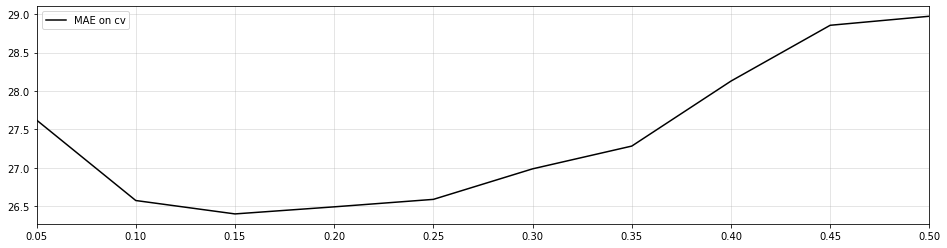

In [17]:
learning_rate = np.linspace(0.05, 0.5, 10)
target = 'learning_rate'
params = {}

lgb = LGBMRegressor()
param_search(lgb, X, y, target, params, learning_rate)

<h3>Что не сработало</h3>

- Обучение на логарифмированном таргете
- Предположение, что фичи почасовых измерений можно отбросить, так как они не добавляют особой точности. Действительно, на эти 720 фичей приходится несущественное улучшение, но всё же улучшение. Без них качество модели на кроссвалидации проседало. 
- XGBRegressor. Работал долго, при этом подгонка параметров так и не приблизила его качество к тому же CB и LGB.
- Использование лейблов кластеризации как фичи давало прирост на кроссвалидации, но только ухудшало скор на трейне. 


<h3>Чего не было в исходном решении</h3>

- Очевидная мысль, вычислить mean/max/min таргета по локации и использовать его, пришла, к сожалению, не сразу.
- В исходном решении не использовался eval_set, тогда я ещё не знал про такую технологию
- Не добрался до того, чтобы преобразовывать фичи. На практике же многие фичи достаточно сильно перекошены (большое значение skew). Была опробована тактика избавления от фичей с самым высоким skew (около 150 штук на удаление), но лучший результат в итоге получился при банальном логарифмировании всего датасета. 